In [1]:
%pylab inline
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import scipy

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cv2
import nltk
import string
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [2]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
import cv2

In [3]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [4]:
# df = pd.read_json('/Users/Home/Desktop/CMPT 459/projectDataset/train.json')

In [161]:
feat_df = pd.read_json(r'C:\Users\HP\Documents\cmpt 459 Kaggle\two_sigma\trainTilltemp3_model_play.json')

In [5]:
print(df.shape)

(49352, 15)


In [6]:
df.tail()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[Elevator, Dishwasher, Hardwood Floors]",40.8433,6824800,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,[https://photos.renthop.com/2/6824800_0682be16...,2800,620 W 171 Street,low
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.8198,6813268,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,[https://photos.renthop.com/2/6813268_1e6fcc32...,2395,3333 Broadway,medium
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[Dining Room, Elevator, Pre-War, Laundry in Bu...",40.5765,6927093,-73.9554,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/6927093_93a52104...,1850,210 Brighton 15th St,medium
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...",40.7448,6892816,-74.0017,c3cd45f4381ac371507090e9ffabea80,[https://photos.renthop.com/2/6892816_1a8d087a...,4195,350 West 21st Street,medium
124009,1.0,3,d89f514c3ed0abaae52cba7017ac0701,2016-04-20 05:34:00,***PRIME MIDTOWN EAST OFF PARK AVE***TRUE 3 BE...,E 54th St,"[Dining Room, Elevator, Laundry in Building, D...",40.7594,6901023,-73.9712,e90f2ded843cdb2efd65ef47d9fc8029,[https://photos.renthop.com/2/6901023_02052d90...,4280,123 E 54th St,high


In [8]:
df['created'] = df['created'].map(pd.to_datetime)

In [11]:
def get_hour(dt):
    return dt.hour
# creating a new hour column
df['hour'] = df['created'].map(get_hour)

In [12]:
df.shape

(49352, 16)

In [4]:
lower_bound = 0.005
upper_bound = 0.995

In [5]:
res = df.price.quantile([lower_bound, upper_bound])
true_index = (res.loc[lower_bound] < df.price.values) & (df.price.values < res.loc[upper_bound])
df.price[true_index].shape
# true_index
# new_df = df

(48839,)

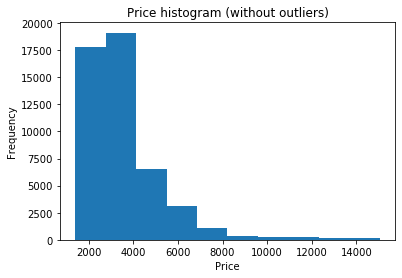

In [6]:
plt.hist(df.price[true_index])
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price histogram (without outliers)")
plt.show()

In [7]:
df.loc[df.price == df.price[true_index].max()]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
92641,2.5,3,63025b68e739a0ed3b969c9d7f0fbffb,2016-04-28 02:27:39,CooperCooper.com :: Listing ID #12_0722; Acces...,West 77th Street,"[Doorman, Fitness Center, Elevator, Balcony, L...",40.7824,6935564,-73.9805,6e5c10246156ae5bdcd9b487ca99d96a,[https://photos.renthop.com/2/6935564_0c783013...,15046,227 West 77th Street,low


In [8]:
new_df = df.loc[true_index]
new_df.shape

(48839, 15)

In [9]:
missing_index = (new_df.longitude == 0)
missing_index = ~missing_index
# missing_index.value_counts()
new_df = new_df.loc[missing_index]
new_df.shape

(48828, 15)

In [10]:
from sklearn.metrics.pairwise import manhattan_distances

In [11]:
downtown = [40.7209, -74.0007]

def man_distances(row):
    dist = manhattan_distances([[row.latitude, row.longitude]], [downtown])
    return dist


new_df['dt_distance'] = new_df.apply(lambda row: man_distances(row), axis=1)

# for index, row in new_df.iterrows():
#     row.dt_distance = manhattan_distances([[row.latitude, row.longitude]], [downtown])

In [12]:
new_df.dt_distance.max()

array([[50.9786]])

In [13]:
# df.loc[df.price == df.price[true_index].max()]

new_df.loc[new_df.dt_distance >= 0.9]

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,dt_distance
872,1.0,2,de47025fe5e6d20a1360cb3efe8c8348,2016-06-11 06:44:25,"Spacious two bedroom, corner unit with...",32 Garrison Street,"[Elevator, Cats Allowed, Dogs Allowed]",42.3459,7143730,-71.0794,c090563865adf7dd1c953e9d6bd65318,[https://photos.renthop.com/2/7143730_775991d2...,4186,32 Garrison Street,low,[[4.546299999999988]]
4719,2.0,2,51052daba3eae7ee4e27bf436f7eb5a9,2016-06-27 02:48:10,Super Spacious Renovated 2BR/2BATH with Home O...,84 Street,"[Private Outdoor Space, Dishwasher, Hardwood F...",42.8724,7221153,-73.4662,5856ea690d343df5f3bc66315babb280,[https://photos.renthop.com/2/7221153_0160c1e4...,2300,1844 84 Street,low,[[2.685999999999993]]
18267,1.0,2,0,2016-06-29 02:30:45,"Huge bedrooms, windows in every room! Hard woo...",1st Ave. Loop,"[Elevator, Laundry in Building, Dishwasher, Ha...",43.0346,7229074,-76.6336,f44a6215f74f901ac7e326207f2984f7,[https://photos.renthop.com/2/7229074_14de73ea...,3300,250 1st Ave. Loop,low,[[4.946600000000004]]
24747,1.0,1,253df0eb4ce61b5bcb695a440606c58d,2016-06-12 03:46:05,Stunning one bedroom apartment with dr...,56 St. Botolph Street,"[Elevator, Cats Allowed, Dogs Allowed]",42.3459,7146153,-71.0794,6a393c2a7ce242d016fb0170ed19aa61,[https://photos.renthop.com/2/7146153_6c1b933d...,4123,56 St. Botolph Street,low,[[4.546299999999988]]
39046,1.0,1,2adec6e74a834940cde0f05a8684d08f,2016-06-16 04:28:15,Lenox Farms Apartments & Town Homes of...,550 Liberty Street,"[Fitness Center, Cats Allowed, Dogs Allowed]",42.2019,7169135,-70.9846,50ef6c51bfe99f33e459ab902190e87f,[https://photos.renthop.com/2/7169135_9a47ffdd...,2140,550 Liberty Street,low,[[4.497099999999996]]
39798,1.0,1,117aceb94c48bfd1f3066a22f999705f,2016-06-17 02:10:25,NO FEE 1 bedroom - Great Elevator - Laundry B...,"E 38th St,","[Elevator, Walk in Closet(s), High Ceilings, H...",34.0126,7174857,-118.2710,f19288238987b18a693e16ee23720c20,[https://photos.renthop.com/2/7174857_6d71b6e1...,2425,"234 E 38th St,",low,[[50.97860000000001]]
41022,2.0,2,2adec6e74a834940cde0f05a8684d08f,2016-06-24 05:28:35,Lenox Farms Apartments & Town Homes of...,550 Liberty Street,"[Fitness Center, Cats Allowed, Dogs Allowed]",42.2019,7209113,-70.9846,43389561311270c553bb83a168a07a6b,[https://photos.renthop.com/2/7209113_f37eb785...,2709,550 Liberty Street,low,[[4.497099999999996]]
57131,1.0,1,2adec6e74a834940cde0f05a8684d08f,2016-05-28 03:50:27,Lenox Farms Apartments & Town Homes of...,550 Liberty Street,"[Fitness Center, Cats Allowed, Dogs Allowed]",42.2019,7079426,-70.9846,43389561311270c553bb83a168a07a6b,[https://photos.renthop.com/2/7079426_dc48b760...,2308,550 Liberty Street,low,[[4.497099999999996]]
62409,1.0,1,3dd500218fd52811b282f5af28a0961f,2016-05-06 04:27:33,Vacant,300 2nd Avenue,"[Elevator, Fitness Center, Cats Allowed, Dogs ...",42.3033,6974621,-71.2133,602fee16546f42bfa81f4adc05261cfa,[https://photos.renthop.com/2/6974621_11136b2c...,2889,300 2nd Avenue,low,[[4.369799999999991]]
72896,1.0,0,2fc165040867a7c3694de4b4a63b1062,2016-05-07 10:34:35,Bright UES studio apartment! Only two flights ...,E 78th St between First and York,[],41.7530,6981117,-87.6134,ee89e559c627af61e8730ea4ad7011d6,[https://photos.renthop.com/2/6981117_2428e796...,2000,452 E 78th St #2A (First Ave & York Ave),low,[[14.644800000000004]]


In [14]:
res = new_df.longitude.quantile([lower_bound, upper_bound])
true_index = (res.loc[lower_bound] < new_df.longitude.values) & (new_df.longitude.values < res.loc[upper_bound])
true_index
new_df.longitude[true_index].describe()

count    48329.000000
mean       -73.973306
std          0.026293
min        -74.017900
25%        -73.991700
50%        -73.978000
75%        -73.955200
max        -73.832500
Name: longitude, dtype: float64

In [15]:
new_df = new_df.loc[true_index]
new_df.shape

(48329, 16)

# Feature Stuff

In [18]:
featureSet = set()
for row in new_df.features:
    for item in row:
        if(len(item) < 15):
            featureSet.add(item.lower())
print((list(featureSet)))

['shares ok', 'atm', 'baruch', 'just listed', 'valet service', 'a/c', 'window kitchen', 'roofdeck', 'free storage', 'new reno', 'renovated apt', 'rooftop deck', 'hi rise', '2 months free', 'pets welcome', 'duplex layout', 'small dogs ok', 'steam room', 'pre-war charm', 'great share', 'quiet', '1 br or conv 2', 'no broker fee', '24hr doorman', '65th/2nd ave', 'patio', 'large rooms', 'microwave', 'pets allowed', 'laundry', 'pet friendly', 'exposed brick', '79th/2nd', 'wash/dryer', 'dogs allowed', 'game room', 'cold storage', 'spa center', 'roof-deck', 'free gym', 'satellite tv', 'new', 'just renovated', 'skyline view', 'party room', '3 bath', 'loft area', 'built in ac', 'pre-war', 'no broker fee!', 'duplex', '\xa0subway', 'lounge spaces', 'new electric', 'outdoor pool', 'bluetooth', 'wifi', 'hardwood', 'short term', 'foyer', 'flex two bed', 'julian balcony', 'wi-fi access', 'kids playroom', 'dish washer', 'heat included', 'gramercy', '24hr doormen', 'terrace', 'fireplace', 'private patio

In [22]:
def extractFeature(name, df, series, array):
    feature = pd.Series(False, df.index, name=name)
    for row, word in enumerate(series):
        feature.iloc[row] = 0
        for item in array:
            if item in word:
                feature.iloc[row] += 1
    df[name] = feature
    return(df)

In [25]:
pet_policy = ['Cats Allowed', 'Dogs Allowed']

new_df = extractFeature('pet_policy', new_df, new_df.features, pet_policy)

In [26]:
listing_type = ['No Flexes', 'Exclusive', 'Sublet', 'Lease-Break', 'Short Term Allowed']

new_df = extractFeature('listing_type', new_df, new_df.features, listing_type)

In [27]:
unit_features =  ['Furnished', 'Laundry In Unit', 'Private Outdoor Space', 'Parking Space', 'Dishwasher']

new_df = extractFeature('unit_features', new_df, new_df.features, unit_features)

In [28]:
building_features = ['Doorman', 'Elevator', 'Fitness Center', 'Laundry In Building', 'Common Outdoor Space', 'Storage Facility']

new_df = extractFeature('building_features', new_df, new_df.features, building_features)

In [30]:
new_df.listing_type.max()

3

In [19]:
# sam_df = pd.DataFrame({'num_legs': [['Cats Allowed', 'Dogs Allowed'], ['Dogs Allowed'],['Cats Allowed'], []],
#                    'num_wings': [2, 0, 0, 0],
#                    'num_specimen_seen': [10, 2, 1, 8]},
#                   index=['falcon', 'dog', 'spider', 'fish'])

In [24]:
# pet_policy = ['Cats Allowed', 'Dogs Allowed']

# sam_df = extractFeature('pet_policy', sam_df, sam_df.num_legs, pet_policy)
# sam_df

,num_legs,num_wings,num_specimen_seen,pet_policy
falcon,"[Cats Allowed, Dogs Allowed]",2,10,2
dog,[Dogs Allowed],0,2,1
spider,[Cats Allowed],0,1,1
fish,[],0,8,0


# Description Stuff

In [32]:
#remove punctuation
def noPunct(row):
    noPunctuation = "".join([c for c in row['description'] if c not in string.punctuation])
    return noPunctuation.lower()

new_df['temp1'] = new_df.apply (lambda row: noPunct(row), axis=1)

In [34]:
# tokenize
tokenizer = RegexpTokenizer(r'\w+')    
new_df['temp2'] = new_df['temp1'].apply (lambda x: tokenizer.tokenize(x))

In [35]:
#remove stopwords
def removStopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

new_df['temp3'] = new_df['temp2'].apply(lambda x : removStopwords(x))

In [160]:
f.to_json(r'C:\Users\HP\Documents\cmpt 459 Kaggle\two_sigma\train_wordsfromDesc.json')

In [7]:
#lemmatize the words
lemmatizer = WordNetLemmatizer()
def wordLemmatizer(text):
    lemmatizedWord = [lemmatizer.lemmatize(i) for i in text]
    return lemmatizedWord

new_df['temp4'] = new_df['temp3'].apply(lambda x : wordLemmatizer(x))

In [8]:
#convert into string
def listToString(row):
    my_string = ' '.join(row['temp4'])
    return my_string

new_df['temp5'] = new_df.apply (lambda row: listToString(row), axis=1)

In [14]:
new_df.shape

(48329, 27)

In [11]:
#remove words not in dictionary
words = set(nltk.corpus.words.words())
def wordsInDict(text):
    engText = " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words and len(w)>1)# or not w.isalpha())
    return engText

new_df['temp6'] = new_df['temp5'].apply(lambda x : wordsInDict(x))

In [13]:
# create list of words and count their occurrences
words_list = []
count = 0
word_count = 0
remove_word_count = 0
for row in new_df.temp6:
    words_list += row.split()
    
counter_obj = Counter(words_list)
words_list = counter_obj.most_common()

# remove words that occur less than 1000 (uncommon)
remove_words = set()
count = 0
unikCount = 0
for word in words_list:
    if(word[1] < 1000):
        remove_words.add(word[0])
        if(word[1] < 1000):
            count += word[1]
            unikCount += 1
print(count)
print(unikCount)

def removeRareWords(text):
    engText = " ".join(w for w in text.split() if w not in remove_words)
    return engText
    
new_df['temp7'] = new_df['temp6'].apply(lambda x : removeRareWords(x))

433350
7594


In [15]:
# create final set of words
finalWordsSet = set()
for row in new_df.temp7:
    ls=row.split()
    if(len(ls) > 0):     
        for item in ls:
            finalWordsSet.add(item)
#print(len(list(finalWordsSet)))

# calculate tf-idf for the words
vectorizer = TfidfVectorizer()
ls = []
for row in new_df.temp7:
    ls += [row]
#print(type(ls))
vectors = vectorizer.fit_transform(ls)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()

desc_df = pd.DataFrame(denselist, columns=feature_names)

In [21]:
desc_df.shape

(48329, 377)

In [121]:
m.to_json(r'C:\Users\HP\Documents\cmpt 459 Kaggle\two_sigma\selected_features.json')

In [29]:
interest_level = new_df['interest_level']

In [26]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

In [30]:
sel_mutual = SelectKBest(mutual_info_classif, k=7)
Desc_mutual = sel_mutual.fit_transform(desc_df, interest_level)
print(sel_mutual.get_support())

[False False False False False False False False False  True  True False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [123]:
mm = desc_df

# mm[mm.rows[sel_mutual.get_support()]]
# mm.head()
# mm[(sel_mutual.get_support()).index[sel_mutual.get_support()]]
m = mm.loc[:, sel_mutual.get_support()]
m.shape

SyntaxError: invalid syntax (<ipython-input-123-31d49e6c535d>, line 6)

In [145]:
# a = orig_df.reset_index(drop=True)
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48329 entries, 0 to 48328
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        48329 non-null  float64
 1   bedrooms         48329 non-null  int64  
 2   building_id      48329 non-null  object 
 3   created          48329 non-null  int64  
 4   description      48329 non-null  object 
 5   display_address  48329 non-null  object 
 6   features         48329 non-null  object 
 7   latitude         48329 non-null  float64
 8   listing_id       48329 non-null  int64  
 9   longitude        48329 non-null  float64
 10  manager_id       48329 non-null  object 
 11  photos           48329 non-null  object 
 12  price            48329 non-null  int64  
 13  street_address   48329 non-null  object 
 14  interest_level   48329 non-null  object 
 15  hour             48329 non-null  int64  
 16  dt_distance      48329 non-null  float64
 17  subway_dista

In [122]:
m.head()

,apartment,appliance,bedroom,floor,kitchen,pa,room
0,0.000000,0.000000,0.108624,0.110607,0.098530,0.128425,0.000000
1,0.144399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.323540,0.080271,0.070551,0.000000,0.063995,0.083412,0.086122
3,0.154491,0.095824,0.084221,0.085758,0.076394,0.000000,0.205618
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.141007,0.000000


In [77]:
for row in m:
    del orig_df[row]
#     print(row)

In [146]:
# orig_df['apartment'] = m['apartment']
# del orig_df['apartment']
# orig_df.info()
f = pd.concat([a, m], axis=1)
f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48329 entries, 0 to 48328
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        48329 non-null  float64
 1   bedrooms         48329 non-null  int64  
 2   building_id      48329 non-null  object 
 3   created          48329 non-null  int64  
 4   description      48329 non-null  object 
 5   display_address  48329 non-null  object 
 6   features         48329 non-null  object 
 7   latitude         48329 non-null  float64
 8   listing_id       48329 non-null  int64  
 9   longitude        48329 non-null  float64
 10  manager_id       48329 non-null  object 
 11  photos           48329 non-null  object 
 12  price            48329 non-null  int64  
 13  street_address   48329 non-null  object 
 14  interest_level   48329 non-null  object 
 15  hour             48329 non-null  int64  
 16  dt_distance      48329 non-null  float64
 17  subway_dista

In [151]:
f.info()
print(f.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48329 entries, 0 to 48328
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        48329 non-null  float64
 1   bedrooms         48329 non-null  int64  
 2   building_id      48329 non-null  object 
 3   created          48329 non-null  int64  
 4   description      48329 non-null  object 
 5   display_address  48329 non-null  object 
 6   features         48329 non-null  object 
 7   latitude         48329 non-null  float64
 8   listing_id       48329 non-null  int64  
 9   longitude        48329 non-null  float64
 10  manager_id       48329 non-null  object 
 11  photos           48329 non-null  object 
 12  price            48329 non-null  int64  
 13  street_address   48329 non-null  object 
 14  interest_level   48329 non-null  object 
 15  hour             48329 non-null  int64  
 16  dt_distance      48329 non-null  float64
 17  subway_dista

In [120]:
# orig_df.append( m['apartment'])
# del orig_df['apartment']
temp = orig_df
temp['apartment'] = pd.Series(m['apartment'].values)
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48329 entries, 4 to 124009
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        48329 non-null  float64
 1   bedrooms         48329 non-null  int64  
 2   building_id      48329 non-null  object 
 3   created          48329 non-null  int64  
 4   description      48329 non-null  object 
 5   display_address  48329 non-null  object 
 6   features         48329 non-null  object 
 7   latitude         48329 non-null  float64
 8   listing_id       48329 non-null  int64  
 9   longitude        48329 non-null  float64
 10  manager_id       48329 non-null  object 
 11  photos           48329 non-null  object 
 12  price            48329 non-null  int64  
 13  street_address   48329 non-null  object 
 14  interest_level   48329 non-null  object 
 15  hour             48329 non-null  int64  
 16  dt_distance      48329 non-null  float64
 17  subway_dist

In [86]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77886 entries, 0 to 124009
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   bathrooms        48329 non-null  float64       
 1   bedrooms         48329 non-null  float64       
 2   building_id      48329 non-null  object        
 3   created          48329 non-null  datetime64[ns]
 4   description      48329 non-null  object        
 5   display_address  48329 non-null  object        
 6   features         48329 non-null  object        
 7   latitude         48329 non-null  float64       
 8   listing_id       48329 non-null  float64       
 9   longitude        48329 non-null  float64       
 10  manager_id       48329 non-null  object        
 11  photos           48329 non-null  object        
 12  price            48329 non-null  float64       
 13  street_address   48329 non-null  object        
 14  interest_level   48329 non-null  obje

In [154]:
f["created"] = pd.to_datetime(f["created"])
f["created_year"] = f["created"].dt.year
f["created_month"] = f["created"].dt.month
f["created_day"] = f["created"].dt.day

In [155]:
num_feats = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
             "created_year", "created_month", "created_day", "dt_distance", "apartment", "appliance", "bedroom", "floor", "kitchen", "pa", "room"]
X = f[num_feats]
y = f["interest_level"]
X.head()
y.head()

0    medium
1       low
2    medium
3    medium
4       low
Name: interest_level, dtype: object

In [156]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [158]:
from sklearn.ensemble import RandomForestClassifier

In [159]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.6972466363722626

In [35]:
print(Desc_mutual)

[[0.         0.         0.10862419 ... 0.09852973 0.12842507 0.        ]
 [0.14439861 0.         0.         ... 0.         0.         0.        ]
 [0.32353959 0.08027111 0.07055127 ... 0.06399493 0.08341191 0.08612232]
 ...
 [0.09530237 0.11822397 0.1039085  ... 0.         0.12284978 0.        ]
 [0.07274833 0.         0.07931775 ... 0.07194674 0.         0.        ]
 [0.10029703 0.         0.2187084  ... 0.0991919  0.         0.        ]]


In [166]:
# df["num_photos"] = df["photos"].apply(len)
# df["num_features"] = df["features"].apply(len)
# df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
feat_df["created"] = pd.to_datetime(feat_df["created"])
feat_df["created_year"] = feat_df["created"].dt.year
feat_df["created_month"] = feat_df["created"].dt.month
feat_df["created_day"] = feat_df["created"].dt.day

In [167]:
feat_df.shape

(48329, 26)

In [193]:
def retNum(num):
    return num[0][0]
# feat_df['dt_distance']=
feat_df["dt_distance"] = feat_df["dt_distance"].apply(lambda x: retNum(x))
feat_df.dt_distance.head()

4     0.0569
6     0.0589
9     0.0748
10    0.0646
15    0.0494
Name: dt_distance, dtype: float64

In [194]:
num_feats = ["bathrooms", "bedrooms", "latitude", "longitude", "price", "dt_distance",
             "created_year", "created_month", "created_day", 'pet_policy', 'listing_type', 'unit_features', 'building_features']
X = feat_df[num_feats]
y = feat_df["interest_level"]
X.head()
y.head()

4     medium
6        low
9     medium
10    medium
15       low
Name: interest_level, dtype: object

In [152]:
f.interest_level.isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
48324    False
48325    False
48326    False
48327    False
48328    False
Name: interest_level, Length: 48329, dtype: bool

# Train model

In [196]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [197]:
clf = RandomForestClassifier(n_estimators=1000)
# clf = SVC(gamma='auto', probability=True)
clf.fit(X_train, y_train)
y_val_pred = clf.predict_proba(X_val)
log_loss(y_val, y_val_pred)

0.6631917764208066

In [28]:
df = pd.read_json(open("/Users/Home/Desktop/CMPT 459/projectDataset/test.json"))
print(df.shape)
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day
X = df[num_feats]

y = clf.predict_proba(X)

(74659, 14)


In [21]:
labels2idx = {label: i for i, label in enumerate(clf.classes_)}
labels2idx

{'high': 0, 'low': 1, 'medium': 2}

In [23]:
sub = pd.DataFrame()
sub["listing_id"] = df["listing_id"]
for label in ["high", "medium", "low"]:
    sub[label] = y[:, labels2idx[label]]
sub.to_csv("submission_rf.csv", index=False)

# Feature Stuff